In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
face_detector=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


Here we import the files, and the haarcascade, also convert the images to greyscale

In [ ]:
os.chdir(r"C:\Users\liamp\Documents\compvis\sarc2.0\genki")
face_detector=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')





os.chdir(r"C:\Users\liamp\Documents\compvis\sarc2.0\genki")

with open('labels.txt') as l:
    labels = l.readlines()
    
mystring = 'file0000'

filenames = []
for i in range(1,4001):
    no = str(i)
    filenames.append(mystring[0:4]+mystring[4:(8-len(no))]+no+'.jpg')

images = []
greyimages = []
smile = []

os.chdir(r"C:\Users\liamp\Documents\compvis\sarc2.0\genki\files")

for i,l in zip(filenames,labels):
    filename = i
    images.append(cv2.imread(filename)[:,:,::-1])
    greyimages.append(cv2.cvtColor(cv2.imread(filename)[:,:,::-1], cv2.COLOR_BGR2GRAY))
    smile.append(int(l[0]))

print(len(images))

we now process the data by applying the haarcascade to each image and crop the image where the face is, then resize to the given width and height.

For the test data we also take cropped image and then append these to the original data, to augment the traning data somewhat.

In [7]:
def process(height,width):


    X_train, X_test, y_train, y_test = train_test_split(greyimages,smile, test_size=0.3, random_state=27)

    X_test, X_val,y_test,y_val = train_test_split(X_test,y_test, test_size=0.5, random_state=27)
    def rs(d):    
        i64 = []
        for b in d:
            i64.append(cv2.resize(b,(height,width), interpolation = cv2.INTER_AREA))
        return i64
    gb = X_train
    smil = y_train


    nye = []
    nye_smile = []
    for a,s in zip(gb,smil):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x,y,w,h]  = box
                nye.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile.append(s)
        except:
            0
     
    nye_test = []
    nye_smile_test = []
    for a,s in zip(X_test,y_test):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x ,y,w,h]  = box
                nye_test.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_test.append(s)
        except:
            nye_test.append(a)
            nye_smile_test.append(s)
        
    X_test_64 = nye_test
    y_test = nye_smile_test

    
    
    nye_val = []
    nye_smile_val = []
    for a,s in zip(X_val,y_val):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x ,y,w,h]  = box
                nye_val.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_val.append(s)
        except:
            nye_val.append(a)
            nye_smile_val.append(s)
        
    X_val_64 = nye_val
    y_val = nye_smile_val
    
    
    
    X_train_64 = rs(X_train)
    X_train_64_aug = np.concatenate((X_train_64,nye),axis=0)
    y_train_aug = np.concatenate((y_train,nye_smile),axis=0)


    X_train_64_aug = np.expand_dims(X_train_64_aug,axis=-1)


    X_test_64 = np.expand_dims(rs(X_test_64),axis=-1)
    X_val_64 = np.expand_dims(rs(X_val_64),axis=-1)
    return X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test
height = 64
width = 64
X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test = process(height,width)

In [5]:
np.shape(X_train_64_aug)

(5437, 64, 64, 1)

### model

In [6]:
print(len(X_train_64_aug),len(X_test_64),len(X_val_64))

5437 560 552


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Dense,Dropout, Input,MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate,LSTM,Reshape,Bidirectional
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 64, 64, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 61, 61, 12)        204       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 12)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 12)       48        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 30, 30, 12)        0         
                                                        

37/37 [==============================] - 1s 39ms/step - loss: 0.1863 - accuracy: 0.9220 - val_loss: 0.2729 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 32/200
37/37 [==============================] - 2s 44ms/step - loss: 0.1922 - accuracy: 0.9216 - val_loss: 0.2392 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 33/200
37/37 [==============================] - 2s 41ms/step - loss: 0.1680 - accuracy: 0.9364 - val_loss: 0.2669 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 34/200
37/37 [==============================] - 2s 41ms/step - loss: 0.1675 - accuracy: 0.9331 - val_loss: 0.2730 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 35/200
37/37 [==============================] - 1s 37ms/step - loss: 0.1593 - accuracy: 0.9351 - val_loss: 0.2912 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 36/200
37/37 [==============================] - 1s 40ms/step - loss: 0.1570 - accuracy: 0.9391 - val_loss: 0.2884 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 37/200
37/37 [==============================] - 1s 34ms/step - loss: 0.

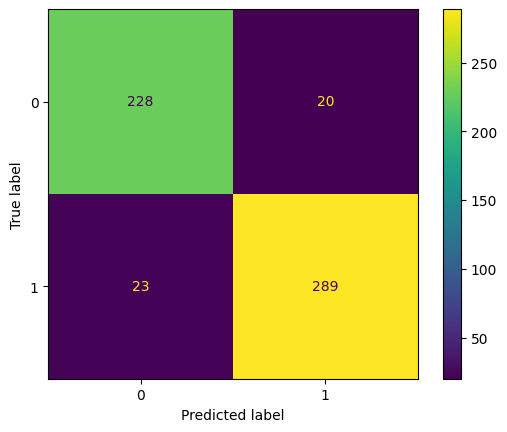

In [8]:
t = tf.keras.utils.to_categorical(y_train_aug,num_classes=2)
v= tf.keras.utils.to_categorical(y_val,num_classes=2)

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(height,width,1,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(12, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(28, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(68, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('smile-net.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


model.fit([X_train_64_aug],t,batch_size=150,epochs=200,validation_data=([X_val_64],v),callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

pred_e2 = model.predict([X_test_64])
label_e2 = np.argmax(pred_e2,axis=1)
print('F1:',f1_score(y_test,label_e2))
print('accuracy:',accuracy_score(y_test,label_e2))
print('precision',precision_score(y_test,label_e2))
print('recall',recall_score(y_test,label_e2))
ConfusionMatrixDisplay.from_predictions(y_test,label_e2)

18/18 [==============================] - 0s 5ms/step
F1: 0.930756843800322
accuracy: 0.9232142857142858
precision 0.9352750809061489
recall 0.9262820512820513


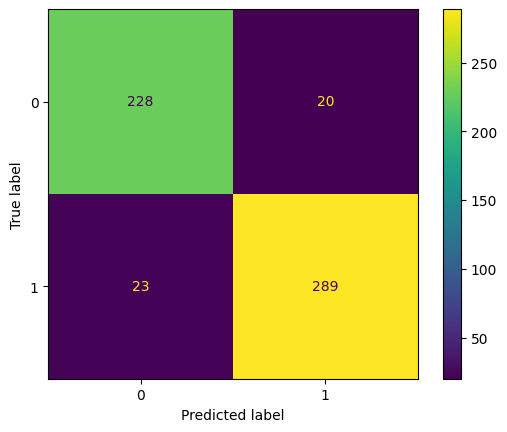

In [9]:
pred_e2 = model.predict([X_test_64])
label_e2 = np.argmax(pred_e2,axis=1)
print('F1:',f1_score(y_test,label_e2))
print('accuracy:',accuracy_score(y_test,label_e2))
print('precision',precision_score(y_test,label_e2))
print('recall',recall_score(y_test,label_e2))
ConfusionMatrixDisplay.from_predictions(y_test,label_e2)

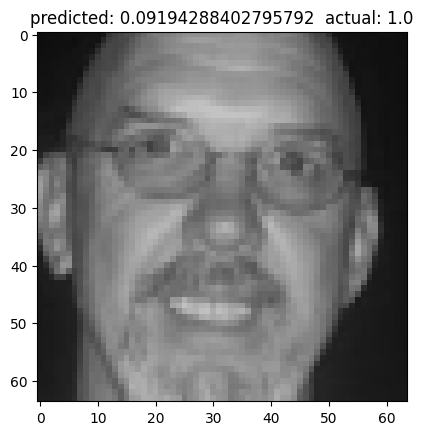

In [10]:
import pandas as pd
check = pd.DataFrame(zip(X_test_64,y_test,pred_e2[:,1]),columns=['pic','smile','pred'])
incorrect = check.where(check['smile']!=np.around(check['pred'])).dropna()

import random
Ncheck = random.randint(0,len(incorrect))
plt.imshow(incorrect['pic'].to_list()[Ncheck],cmap='gray', vmin=0, vmax=255)
titel = 'predicted: ' + str(incorrect['pred'].to_list()[Ncheck])+'  '+'actual: '+str(incorrect['smile'].to_list()[Ncheck])
plt.title(titel)
plt.show()

Now we can try augmenting the data, here we create functions to rotate the image clockwise and anticlockwise by a random angle between 20 and 40. We also pad the images on the top,bottom,left and right by a random number between 20 and 50. We can also apply both rotation and padding for more data samples.


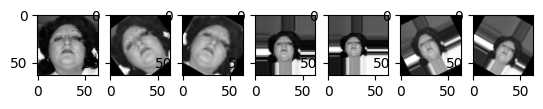

In [8]:
import random
fix,ax = plt.subplots(1,7)

N = random.randint(0,len(X_train_64_aug))
image = X_train_64_aug[N]

def rotate_imagep(image):
  ang = random.randint(20,40)
  cent = tuple(np.array(image.shape[1::-1]) / 2)
  RM = cv2.getRotationMatrix2D(cent, ang, 1.0)
  rot = cv2.warpAffine(image, RM, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return rot
def rotate_imagen(image):
  ang = -random.randint(20,40)
  cent = tuple(np.array(image.shape[1::-1]) / 2)
  RM = cv2.getRotationMatrix2D(cent, ang, 1.0)
  rot = cv2.warpAffine(image, RM, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return rot


def pad_and_crop(image):
    [top,bottom,left,right] = np.random.randint(20,50,(1,4))[0]

    imagepad = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    result = cv2.resize(imagepad,(64,64), interpolation = cv2.INTER_AREA)
    return result




pcimage1 = pad_and_crop(image)
pcimage2 = pad_and_crop(image)

rimage1 = rotate_imagep(image)
rimage2 = rotate_imagen(image)

pcrimage1 =rotate_imagep(pad_and_crop(image))
pcrimage2 = rotate_imagen(pad_and_crop(image))

ax[0].imshow(image,cmap='gray')
ax[1].imshow(rimage1,cmap='gray')
ax[2].imshow(rimage2,cmap='gray')
ax[3].imshow(pcimage1,cmap='gray')
ax[4].imshow(pcimage2,cmap='gray')
ax[5].imshow(pcrimage1,cmap='gray')
ax[6].imshow(pcrimage2,cmap='gray')




In [9]:
def process(height,width):


    X_train, X_test, y_train, y_test = train_test_split(greyimages,smile, test_size=0.3, random_state=27)

    X_test, X_val,y_test,y_val = train_test_split(X_test,y_test, test_size=0.5, random_state=27)
    def rs(d):    
        i64 = []
        for b in d:
            i64.append(cv2.resize(b,(height,width), interpolation = cv2.INTER_AREA))
        return i64
    gb = X_train
    smil = y_train


    nye = []
    nye_smile = []
    for a,s in zip(gb,smil):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x,y,w,h]  = box
                face =cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA)
                
                nye.append(face)
                nye_smile.append(s)
                
                pcimage1 = pad_and_crop(face)
                nye.append(pcimage1)
                nye_smile.append(s)
                
                pcimage2 = pad_and_crop(face)
                nye.append(pcimage2)
                nye_smile.append(s)

                rimage1 = rotate_imagep(face)
                nye.append(rimage1)
                nye_smile.append(s)
                
                rimage2 = rotate_imagen(face)
                nye.append(rimage2)
                nye_smile.append(s)

                pcrimage1 =rotate_imagep(pad_and_crop(face))
                nye.append(pcrimage1)
                nye_smile.append(s)
                
                pcrimage2 = rotate_imagen(pad_and_crop(face))
                nye.append(pcrimage2)
                nye_smile.append(s)
                
                face = cv2.resize(a[y:(y+h),x:(x+w)][:,::-1],(height,width), interpolation = cv2.INTER_AREA)
                nye.append(face)
                nye_smile.append(s)
                
                nye.append(face)
                nye_smile.append(s)
                
                pcimage1 = pad_and_crop(face)
                nye.append(pcimage1)
                nye_smile.append(s)
                
                pcimage2 = pad_and_crop(face)
                nye.append(pcimage2)
                nye_smile.append(s)

                rimage1 = rotate_imagep(face)
                nye.append(rimage1)
                nye_smile.append(s)
                
                rimage2 = rotate_imagen(face)
                nye.append(rimage2)
                nye_smile.append(s)

                pcrimage1 =rotate_imagep(pad_and_crop(face))
                nye.append(pcrimage1)
                nye_smile.append(s)
                
                pcrimage2 = rotate_imagen(pad_and_crop(face))
                nye.append(pcrimage2)
                nye_smile.append(s)
        except:
            0
     
    nye_test = []
    nye_smile_test = []
    for a,s in zip(X_test,y_test):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x ,y,w,h]  = box
                nye_test.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_test.append(s)
        except:
            nye_test.append(a)
            nye_smile_test.append(s)
        
    X_test_64 = nye_test
    y_test = nye_smile_test

    
    
    nye_val = []
    nye_smile_val = []
    for a,s in zip(X_val,y_val):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x ,y,w,h]  = box
                nye_val.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_val.append(s)
                nye_val.append(cv2.resize(a[y:(y+h),x:(x+w)][:,::-1],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_val.append(s)
                
        except:
            nye_val.append(a)
            nye_smile_val.append(s)
        
    X_val_64 = nye_val
    y_val = nye_smile_val
    
    
    
    X_train_64 = rs(X_train)
    X_train_64_aug = np.concatenate((X_train_64,nye),axis=0)
    y_train_aug = np.concatenate((y_train,nye_smile),axis=0)


    X_train_64_aug = np.expand_dims(X_train_64_aug,axis=-1)


    X_test_64 = np.expand_dims(rs(X_test_64),axis=-1)
    X_val_64 = np.expand_dims(rs(X_val_64),axis=-1)
    return X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test
height = 64
width = 64
X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test = process(height,width)

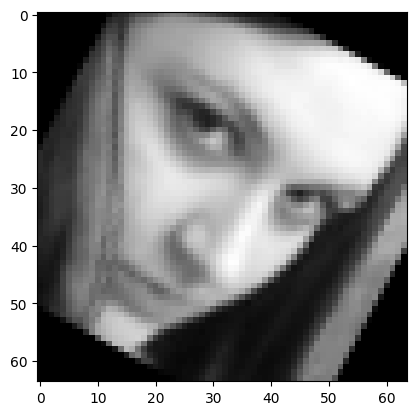

In [13]:
N = random.randint(0,len(X_train_64_aug))

plt.imshow(X_train_64_aug[N],cmap='gray')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 64, 64, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 12)        204       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 12)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 12)       48        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 12)        0         
                                                      

Epoch 30/200
283/283 [==============================] - 8s 30ms/step - loss: 0.1561 - accuracy: 0.9384 - val_loss: 0.1868 - val_accuracy: 0.9303 - lr: 1.0000e-04
Epoch 31/200
18/18 [==============================] - 0s 3ms/step
F1: 0.9548387096774195
accuracy: 0.95
precision 0.961038961038961
recall 0.9487179487179487


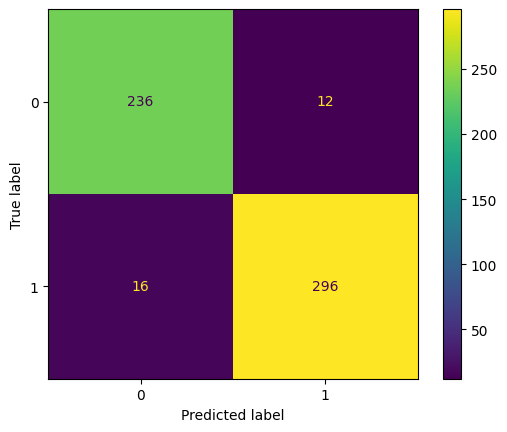

In [12]:
t = tf.keras.utils.to_categorical(y_train_aug,num_classes=2)
v= tf.keras.utils.to_categorical(y_val,num_classes=2)

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(height,width,1,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(12, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(28, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(68, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('smile-net.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


model.fit([X_train_64_aug],t,batch_size=150,epochs=200,validation_data=([X_val_64],v),callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

pred_e2 = model.predict([X_test_64])
label_e2 = np.argmax(pred_e2,axis=1)
print('F1:',f1_score(y_test,label_e2))
print('accuracy:',accuracy_score(y_test,label_e2))
print('precision',precision_score(y_test,label_e2))
print('recall',recall_score(y_test,label_e2))
ConfusionMatrixDisplay.from_predictions(y_test,label_e2)

18/18 [==============================] - 0s 11ms/step
F1: 0.9548387096774195
accuracy: 0.95
precision 0.961038961038961
recall 0.9487179487179487


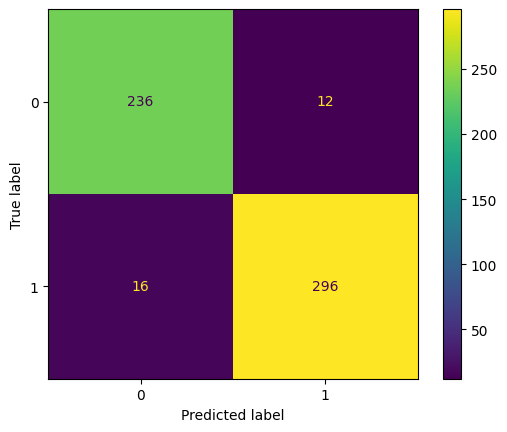

In [13]:
pred_e2 = model.predict([X_test_64])
label_e2 = np.argmax(pred_e2,axis=1)
print('F1:',f1_score(y_test,label_e2))
print('accuracy:',accuracy_score(y_test,label_e2))
print('precision',precision_score(y_test,label_e2))
print('recall',recall_score(y_test,label_e2))
ConfusionMatrixDisplay.from_predictions(y_test,label_e2)

In [17]:
len(X_train_64_aug)

12185

### Experimenting with augmenting smaller amounts of training data


using only 20% of the data for training (with augmentation)

In [18]:
def process(height,width,split):


    X_train, X_test, y_train, y_test = train_test_split(greyimages,smile, test_size=split, random_state=27)

    X_test, X_val,y_test,y_val = train_test_split(X_test,y_test, test_size=0.5, random_state=27)
    def rs(d):    
        i64 = []
        for b in d:
            i64.append(cv2.resize(b,(height,width), interpolation = cv2.INTER_AREA))
        return i64
    gb = X_train
    smil = y_train


    nye = []
    nye_smile = []
    for a,s in zip(gb,smil):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x,y,w,h]  = box
                face =cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA)
                
                nye.append(face)
                nye_smile.append(s)
                
                pcimage1 = pad_and_crop(face)
                nye.append(pcimage1)
                nye_smile.append(s)
                
                pcimage2 = pad_and_crop(face)
                nye.append(pcimage2)
                nye_smile.append(s)

                rimage1 = rotate_imagep(face)
                nye.append(rimage1)
                nye_smile.append(s)
                
                rimage2 = rotate_imagen(face)
                nye.append(rimage2)
                nye_smile.append(s)

                pcrimage1 =rotate_imagep(pad_and_crop(face))
                nye.append(pcrimage1)
                nye_smile.append(s)
                
                pcrimage2 = rotate_imagen(pad_and_crop(face))
                nye.append(pcrimage2)
                nye_smile.append(s)
                
                face = cv2.resize(a[y:(y+h),x:(x+w)][:,::-1],(height,width), interpolation = cv2.INTER_AREA)
                nye.append(face)
                nye_smile.append(s)
                
                nye.append(face)
                nye_smile.append(s)
                
                pcimage1 = pad_and_crop(face)
                nye.append(pcimage1)
                nye_smile.append(s)
                
                pcimage2 = pad_and_crop(face)
                nye.append(pcimage2)
                nye_smile.append(s)

                rimage1 = rotate_imagep(face)
                nye.append(rimage1)
                nye_smile.append(s)
                
                rimage2 = rotate_imagen(face)
                nye.append(rimage2)
                nye_smile.append(s)

                pcrimage1 =rotate_imagep(pad_and_crop(face))
                nye.append(pcrimage1)
                nye_smile.append(s)
                
                pcrimage2 = rotate_imagen(pad_and_crop(face))
                nye.append(pcrimage2)
                nye_smile.append(s)
        except:
            0
     
    nye_test = []
    nye_smile_test = []
    for a,s in zip(X_test,y_test):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x ,y,w,h]  = box
                nye_test.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_test.append(s)
        except:
            nye_test.append(a)
            nye_smile_test.append(s)
        
    X_test_64 = nye_test
    y_test = nye_smile_test

    
    
    nye_val = []
    nye_smile_val = []
    for a,s in zip(X_val,y_val):
        try:
            results = face_detector.detectMultiScale(a, scaleFactor=1.15,minNeighbors=5,minSize=(30, 30))
            for box in results:
                [x ,y,w,h]  = box
                nye_val.append(cv2.resize(a[y:(y+h),x:(x+w)],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_val.append(s)
                nye_val.append(cv2.resize(a[y:(y+h),x:(x+w)][:,::-1],(height,width), interpolation = cv2.INTER_AREA))
                nye_smile_val.append(s)
                
        except:
            nye_val.append(a)
            nye_smile_val.append(s)
        
    X_val_64 = nye_val
    y_val = nye_smile_val
    
    
    
    X_train_64 = rs(X_train)
    X_train_64_aug = np.concatenate((X_train_64,nye),axis=0)
    y_train_aug = np.concatenate((y_train,nye_smile),axis=0)


    X_train_64_aug = np.expand_dims(X_train_64_aug,axis=-1)


    X_test_64 = np.expand_dims(rs(X_test_64),axis=-1)
    X_val_64 = np.expand_dims(rs(X_val_64),axis=-1)
    return X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 64, 64, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 61, 61, 12)        204       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 12)       0         
 g2D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 30, 30, 12)       48        
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 30, 30, 12)        0         
                                                      

41/41 [==============================] - 1s 32ms/step - loss: 0.2231 - accuracy: 0.9056 - val_loss: 0.4553 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 32/200
41/41 [==============================] - 1s 32ms/step - loss: 0.2338 - accuracy: 0.8997 - val_loss: 0.4041 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 33/200
39/41 [===========================>..] - ETA: 0s - loss: 0.2040 - accuracy: 0.9195
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
41/41 [==============================] - 1s 32ms/step - loss: 0.2036 - accuracy: 0.9203 - val_loss: 0.4185 - val_accuracy: 0.8508 - lr: 0.0010
Epoch 34/200
41/41 [==============================] - 1s 32ms/step - loss: 0.1807 - accuracy: 0.9237 - val_loss: 0.4281 - val_accuracy: 0.8508 - lr: 1.0000e-04
Epoch 35/200
41/41 [==============================] - 2s 37ms/step - loss: 0.1738 - accuracy: 0.9293 - val_loss: 0.4422 - val_accuracy: 0.8520 - lr: 1.0000e-04
Epoch 36/200
53/53 [==============================] - 0s 3ms/ste

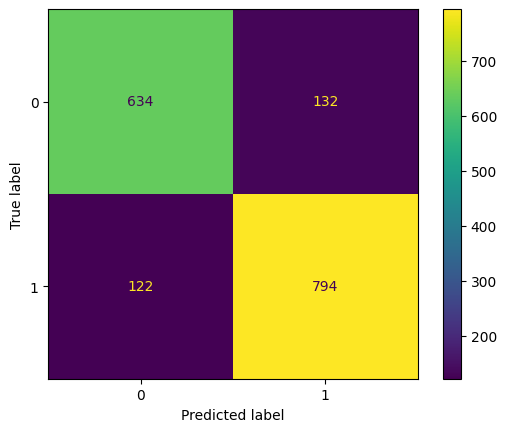

In [23]:
#10% or data for training
height = 64
width = 64
split = 0.9
X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test = process(height,width,split)

t = tf.keras.utils.to_categorical(y_train_aug,num_classes=2)
v= tf.keras.utils.to_categorical(y_val,num_classes=2)

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(height,width,1,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(12, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(28, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(68, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('smile-net.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


model.fit([X_train_64_aug],t,batch_size=150,epochs=200,validation_data=([X_val_64],v),callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

pred_e2 = model.predict([X_test_64])
label_e2 = np.argmax(pred_e2,axis=1)
print('F1:',f1_score(y_test,label_e2))
print('accuracy:',accuracy_score(y_test,label_e2))
print('precision',precision_score(y_test,label_e2))
print('recall',recall_score(y_test,label_e2))
ConfusionMatrixDisplay.from_predictions(y_test,label_e2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 64, 64, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 12)        204       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 12)       0         
 2D)                                                             
                                                                 
 batch_normalization_13 (Bat  (None, 30, 30, 12)       48        
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 30, 30, 12)        0         
                                                      

Epoch 29/200
203/203 [==============================] - 6s 29ms/step - loss: 0.1763 - accuracy: 0.9283 - val_loss: 0.2182 - val_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 30/200
203/203 [==============================] - 6s 31ms/step - loss: 0.1756 - accuracy: 0.9291 - val_loss: 0.2167 - val_accuracy: 0.9154 - lr: 1.0000e-05
Epoch 31/200
29/29 [==============================] - 1s 15ms/step
F1: 0.9391304347826087
accuracy: 0.9319654427645788
precision 0.9548133595284872
recall 0.9239543726235742


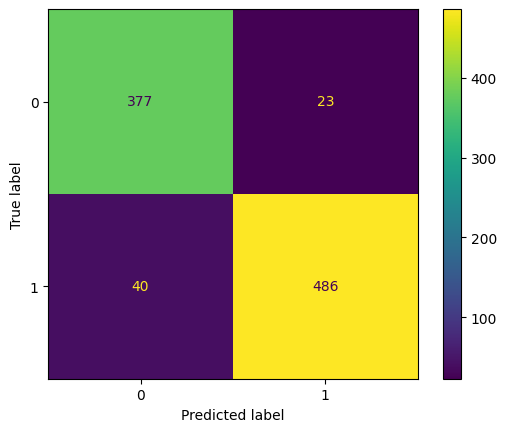

In [20]:
#50% of data for training
height = 64
width = 64
split=0.5
X_train_64_aug,X_val_64,X_test_64,y_train_aug,y_val,y_test = process(height,width,split)

t = tf.keras.utils.to_categorical(y_train_aug,num_classes=2)
v= tf.keras.utils.to_categorical(y_val,num_classes=2)

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(height,width,1,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(12, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(28, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(68, kernel_size=(4, 4), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('smile-net.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


model.fit([X_train_64_aug],t,batch_size=150,epochs=200,validation_data=([X_val_64],v),callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

pred_e2 = model.predict([X_test_64])
label_e2 = np.argmax(pred_e2,axis=1)
print('F1:',f1_score(y_test,label_e2))
print('accuracy:',accuracy_score(y_test,label_e2))
print('precision',precision_score(y_test,label_e2))
print('recall',recall_score(y_test,label_e2))
ConfusionMatrixDisplay.from_predictions(y_test,label_e2)